<a href="https://colab.research.google.com/github/regiltcj/upwork-Envestix/blob/version-2/upwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Objective**
To identify the brands with growth potential from those selling on amazon so that they could be supported with sufficient credits
## **Requirement**
Create a heuristic model that can be used to rank the brands based on the growth potential that in turn indicates their credit worthiness
## **KPIs under consideration**
1. Time series
2. Periodic metrics
3. Snapshot metrics (Sellers/Brand relations)



#### Importing required libraries

In [ ]:
from glob import glob
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as sc

from google.colab import drive
drive.mount("/content/drive")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


#### Reading the dataset

In [ ]:
source_path = "/content/drive/MyDrive/upwork/dataset/"

brand_metrics_daily = pd.read_csv(source_path + "bi_brand_metrics_daily.csv")
brand_metrics_snapshot = pd.read_csv(source_path + "bi_brand_metrics_snapshot.csv")
brand_segmentation = pd.read_csv(source_path + "bi_brand_segmentation.csv")
products = pd.read_csv(source_path + "products.csv")
product_metrics_daily = pd.read_csv(source_path + "bi_product_metrics_daily.csv")
product_offer_snapshots  = pd.read_csv(source_path + "product_offer_snapshots.csv")
product_snapshots  = pd.read_csv(source_path + "product_snapshots.csv")

In [ ]:
print("brand_metrics_daily: {}".format(brand_metrics_daily.shape))
print("brand_metrics_snapshot: {}".format(brand_metrics_snapshot.shape))
print("brand_segmentation: {}".format(brand_segmentation.shape))
print("products: {}".format(products.shape))
print("product_metrics_daily: {}".format(product_metrics_daily.shape))
print("product_offer_snapshots: {}".format(product_offer_snapshots.shape))
print("product_snapshots: {}".format(product_snapshots.shape))

brand_metrics_daily: (664535, 11)
brand_metrics_snapshot: (4116, 17)
brand_segmentation: (3995, 28)
products: (22922, 14)
product_metrics_daily: (1851006, 9)
product_offer_snapshots: (52264, 15)
product_snapshots: (22922, 20)


In [ ]:
# Checking the number of distinct brands from the 'products' table
print(f"Number of unique brands: {products['brand'].nunique(dropna=False)}")
print(f"Number of brands for which we have the sales data: {brand_metrics_daily['brand'].nunique(dropna=False)}")

# Creating a dataframe of all the unique brands for which we have the sales data for
brands = pd.DataFrame(products.loc[~products["brand"].isna(),"brand"])
brands.drop_duplicates(ignore_index=True, inplace=True)
brands

Number of unique brands: 4126
Number of brands for which we have the sales data: 4005


,brand
0,CLUE
1,Black N Red
2,Patriot Wholesale Direct
3,STMT
4,WE'RE NOT REALLY STRANGERS
...,...
4120,ImageMat
4121,Launch X431
4122,JIM OSBORN REPRODUCTIONS
4123,JIM OSBORN REPRODUCTIONS


i.e. We need to create a scoring mechanism the provides scores to each of the 4125 brands and could be used to find the low risk brands for investing

- **Brand sells its products not/exclusively**
- **Pricing Levels**
- **Amazon Selling**
- **Entropy**

### ***To Do***

Time Series

Trend Analysis - Slope of the trend line
Consistency Analysis - Fraction of weeeks which had positive or stable gorwth to the total number of weeks
- Generic
  1. Provide -1 (bad score) to those brands that does not have sufficient data for time series analysis
  2. Chooose only top x categories that contribute to the 90% of total value (sales/items)
  3. Sum the scores of trend analysis and consistency analysis to arrive at the total score for the brand
  4. Time sereis analysis has to be done at category level (using brand_metrics_daily) and then aggregated using weighted sum fro all the KPI except for pricing. For pricing, we can use bi_product_metrics_daily

- Sales
  1. Trend Analysis
  2. Consistency Analysis
- Items
  1. Trend Analysis
  2. Consistency Analysis
- Sales share
  1. Scale the total score between -1 to 1
  2. Consistency Analysis
- Items share
  1. Scale the total score between -1 to 1
  2. Consistency Analysis
  3. Change the calculation of weightage to use item instead of sales

- Review Count
  1. Try to scale the review count to a common scale (ratio wrt catgory average) and then use it for trend analysis
  
- Pricing
  1. Need to work upon the relative pricing within a category - This would be a better option for trend analysis
  2. Scale the total score between -1 to 1
  3. Weekly growthrate similar to sales and items share

Periodic
- out_of_stock_pct
  1. Perform a weihted average based at product level (possibly by sales) and use the weighted sum as aggregator instead of mean

Snapshot
- Pricing
  1. Calculate the ratio instead of difference to arrive at the product level score
  2. Weightage based on daily_sales in product table (bi_product_metrics_daily) to aggregate for brand level

### ***Time Series***
In this list of KPIs, we analyse the trends in the time series data and each of the time serires will be translated to a score (this will be per brand per category). A weighted average (weighted based on the revenue of each category) of the above score across category will provide the score for the brand. 

---
**KPIs**

Using brand_metrics_daily
  1. Sales
  2. Sales_share
  3. Items
  4. Items_share
  5. Reviews count
  6. Reviews score
  7. Number of Products

Using other tables
  6. Competition level
  7. Pricing
---

**Using brand_metrics_daily**

In [ ]:
# Converting the sample_date to dateimte
brand_metrics_daily.loc[:,"sample_date"] = pd.to_datetime(brand_metrics_daily["sample_date"])
brand_metrics_daily.loc[:, "week_number"] = brand_metrics_daily["sample_date"].dt.isocalendar().week

In [ ]:
# Function to get the growth rate (Fit the line and growth would be the slope of the line)
def get_growth_rate(df, field_name):
  scaler = MinMaxScaler()
  df["scaled"] = scaler.fit_transform(df[[field_name]])
  date_oridinal = df["sample_date"].map(dt.datetime.toordinal)
  slope, intercept, r_value, p_value, std_err = sc.linregress(date_oridinal, df["scaled"])
  return slope

# Function to filter the brand-category combination that has sufficient amount of data for trend analysis 
def filter_brand_metrics_daily(df, field_name, filtered_fields, pct, null_filter):
  if null_filter:
    pos_val_count = df.groupby(by=["brand", "category_id"]).apply(lambda x:sum(x[field_name].isna())).reset_index()
  else:
    pos_val_count = df.groupby(by=["brand", "category_id"]).apply(lambda x:sum(x[field_name]>0)).reset_index()
  print(f"Median number of days for which the brand-category combination has non-zero value for {field_name}: {pos_val_count[0].median()}")
  pos_val_count_cum = pos_val_count[0].value_counts(normalize=True).sort_index(ascending=False).cumsum()
  pos_val_days = pos_val_count_cum.loc[pos_val_count_cum>pct].index[0]
  print(f"We have {pct*100}% of the brand-categories having non-zero value for {field_name} for at least {pos_val_days} days.")
  print(f"Hence the analysis would be for those brand-category combinations that has non-zero value for {field_name} for atleast {pos_val_days} days")
  pos_val_count_filtered = pos_val_count.loc[pos_val_count[0]>=pos_val_days]
  df_filtered = pd.merge(df,pos_val_count_filtered, on=["brand","category_id"], how="inner", validate="many_to_one").loc[:,filtered_fields]
  return df_filtered

def category_weight(df, field_name):
  # Computing the weightage for each category to arrive at the final score for the brand
  # Category with more sales is given higher weightage. (Weight is calculated based on the 'fieldname')

  category_weights = df.groupby(by=["brand", "category_id"])[field_name].sum().reset_index()
  # Finding the weightage across all the categories of the brand
  category_weights.loc[:,"weightage"] = category_weights.groupby(by=["brand"])[field_name].transform(lambda x:x/x.sum())
  # Identifying the standard deviation of each group (We are not noramalizing it with N-1 to avoid NaN values)
  category_weights["stddev"] = category_weights.groupby("brand")["weightage"].transform(lambda x:x.std(ddof=0))
  # Filtering the top contributors. Top Contributor - Catgories the weightage is greater than or equal to the standard deviation of the brand
  category_weights = category_weights.loc[category_weights["weightage"] >= category_weights["stddev"], ["brand", "category_id", field_name]]
  category_weights["weightage"] = category_weights.groupby(by=["brand"])[field_name].transform(lambda x:x/x.sum())
  return category_weights

# Function to find the ratio of weeks with positive growth to the total number of weeks
def get_consistency_score(df, field_name, is_threshold):
  threshold = 0
  if is_threshold:
    threshold = 0.1*df[field_name].max()
  return (df[field_name]>threshold).sum()/df.shape[0]

# Function to plot the actual value and the fitted line
def plot_series(df, brand, category_id, field_name):

  temp = df.loc[(df["brand"].eq(brand))&(df["category_id"].eq(category_id)),["sample_date" ,field_name]]
  print(temp.shape)

  scaler = MinMaxScaler()
  temp["scaled"] = scaler.fit_transform(temp[[field_name]])
  date_oridinal = temp["sample_date"].map(dt.datetime.toordinal)

  # Fitting the linear regression for each brand-category combination and finding the slope of the trend
  slope, intercept, r_value, p_value, std_err = sc.linregress(date_oridinal, temp["scaled"])
  print(f"slope - {slope}; r_value - {r_value}; p_value - {p_value}; std_err - {std_err}")
  
  # Predicting the target variable
  temp["predicted"] = intercept + slope*date_oridinal

  # Plotting the actual and predicted value
  temp.index = temp["sample_date"]
  plt.figure(figsize=(24,9))
  plt.title(f"{brand}-{category_id}")
  plt.plot(temp["scaled"])
  plt.plot(temp["predicted"], 'r', label='fitted line')
  plt.xticks(rotation=45)
  plt.show()

##### **Sales** 

In [ ]:
start = dt.datetime.now()
cols = ["brand","category_id","sample_date","daily_sales", "week_number"]
brand_metrics_daily_filtered = filter_brand_metrics_daily(brand_metrics_daily, "daily_sales", cols, 0.9, False)

# Trend score
sales_score = brand_metrics_daily_filtered.groupby(by=["brand", "category_id"]).apply(get_growth_rate,"daily_sales").reset_index()
sales_score.rename(columns={0:"sales_score"}, inplace=True)
category_sales_weightage = category_weight(brand_metrics_daily_filtered, "daily_sales")
weighted_sales_score = pd.merge(category_sales_weightage, sales_score, on=["brand", "category_id"], how="inner")
weighted_sales_score["weighted_sales_score"] = weighted_sales_score["sales_score"]*weighted_sales_score["weightage"]
sales_trend_score = weighted_sales_score.groupby(by="brand")["weighted_sales_score"].sum().reset_index()
sales_trend_score.rename(columns={"weighted_sales_score":"sales_trend_score"}, inplace=True)

# Consistency score
weeekly_sales_growth = brand_metrics_daily_filtered.groupby(by=["brand", "category_id", "week_number"]).apply(get_growth_rate,"daily_sales").reset_index()
weeekly_sales_growth.rename(columns={0:"weekly_sales_score"}, inplace=True)
weeekly_sales_score = weeekly_sales_growth.groupby(by=["brand", "category_id"]).apply(get_consistency_score,"weekly_sales_score", False).reset_index()
weeekly_sales_score.rename(columns={0:"weekly_sales_score"},inplace=True)
weighted_weeekly_sales_score = pd.merge(category_sales_weightage, weeekly_sales_score, on=["brand", "category_id"], how="inner")
weighted_weeekly_sales_score["weighted_weeekly_sales_score"] = weighted_weeekly_sales_score["weekly_sales_score"]*weighted_weeekly_sales_score["weightage"]
sales_consistency_score = weighted_weeekly_sales_score.groupby(by="brand")["weighted_weeekly_sales_score"].sum().reset_index()
sales_consistency_score.rename(columns={"weighted_weeekly_sales_score":"sales_consistency_score"}, inplace=True)
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")

Median number of days for which the brand-category combination has non-zero value for daily_sales: 88.0
We have 90.0% of the brand-categories having non-zero value for daily_sales for at least 60 days.
Hence the analysis would be for those brand-category combinations that has non-zero value for daily_sales for atleast 60 days
Time taken - 429 seconds


In [ ]:
brands = pd.merge(brands, sales_trend_score, on="brand", how="left", validate="one_to_one")
brands = pd.merge(brands, sales_consistency_score, on="brand", how="left", validate="one_to_one")
brands.to_csv(source_path+"/final_scores/sales.csv")

In [ ]:
# sales_score.sort_values(by="weighted_sales_score")

KeyError: ignored

In [ ]:
# weighted_sales_score.sort_values(by="weighted_sales_score")

In [ ]:
# # brand = "Toyvian"
# # category_id = 1069782
# brand = "Mud Pie"
# category_id = 490760011
# plot_series(brand_metrics_daily_filtered, brand, category_id, "daily_sales")

##### **Sales share** 

In [ ]:
start = dt.datetime.now()
cols = ["brand","category_id","sample_date","daily_sales_share", "week_number"]
brand_metrics_daily_filtered = filter_brand_metrics_daily(brand_metrics_daily, "daily_sales_share", cols, 0.9, False)

# Trend score
sales_share_score = brand_metrics_daily_filtered.groupby(by=["brand", "category_id"]).apply(get_growth_rate,"daily_sales_share").reset_index()
sales_share_score.rename(columns={0:"sales_share_score"}, inplace=True)
category_sales_share_weightage = category_weight(brand_metrics_daily_filtered, "daily_sales_share")
weighted_sales_share_score = pd.merge(category_sales_share_weightage, sales_share_score, on=["brand", "category_id"], how="inner")
weighted_sales_share_score["weighted_sales_share_score"] = weighted_sales_share_score["sales_share_score"]*weighted_sales_share_score["weightage"]
sales_share_trend_score = weighted_sales_share_score.groupby(by="brand")["weighted_sales_share_score"].sum().reset_index()
sales_share_trend_score.rename(columns={"weighted_sales_share_score":"sales_share_trend_score"}, inplace=True)

# Consistency score
weeekly_sales_share_growth = brand_metrics_daily_filtered.groupby(by=["brand", "category_id", "week_number"]).apply(get_growth_rate,"daily_sales_share").reset_index()
weeekly_sales_share_growth.rename(columns={0:"weekly_sales_share_score"}, inplace=True)
weeekly_sales_share_score = weeekly_sales_share_growth.groupby(by=["brand", "category_id"]).apply(get_consistency_score,"weekly_sales_share_score", False).reset_index()
weeekly_sales_share_score.rename(columns={0:"weekly_sales_share_score"},inplace=True)
weighted_weeekly_sales_share_score = pd.merge(category_sales_share_weightage, weeekly_sales_share_score, on=["brand", "category_id"], how="inner")
weighted_weeekly_sales_share_score["weighted_weeekly_sales_share_score"] = weighted_weeekly_sales_share_score["weekly_sales_share_score"]*weighted_weeekly_sales_share_score["weightage"]
sales_share_consistency_score = weighted_weeekly_sales_share_score.groupby(by="brand")["weighted_weeekly_sales_share_score"].sum().reset_index()
sales_share_consistency_score.rename(columns={"weighted_weeekly_sales_share_score":"sales_share_consistency_score"}, inplace=True)
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")

Median number of days for which the brand-category combination has non-zero value for daily_sales_share: 88.0
We have 90.0% of the brand-categories having non-zero value for daily_sales_share for at least 60 days.
Hence the analysis would be for those brand-category combinations that has non-zero value for daily_sales_share for atleast 60 days
Time taken - 425 seconds


In [ ]:
brands = pd.merge(brands, sales_share_trend_score, on="brand", how="left", validate="one_to_one")
brands = pd.merge(brands, sales_share_consistency_score, on="brand", how="left", validate="one_to_one")
brands.to_csv(source_path+"/final_scores/sales_share.csv")

In [ ]:
sales_share_score.sort_values(by="weighted_sales_share_score")

In [ ]:
weighted_sales_share_score.sort_values(by="weighted_sales_share_score")

In [ ]:
brand = "BookFactory"
category_id = 490760011
plot_series(brand_metrics_daily_filtered, brand, category_id, "daily_sales_share")

##### **Items** 

In [ ]:
start = dt.datetime.now()
cols = ["brand","category_id","sample_date","daily_items","week_number"]
brand_metrics_daily_filtered = filter_brand_metrics_daily(brand_metrics_daily, "daily_items", cols, 0.9, False)
items_score = brand_metrics_daily_filtered.groupby(by=["brand", "category_id"]).apply(get_growth_rate,"daily_items").reset_index()
items_score.rename(columns={0:"items_score"}, inplace=True)
category_items_weightage = category_weight(brand_metrics_daily_filtered, "daily_items")
weighted_items_score = pd.merge(category_items_weightage, items_score, on=["brand", "category_id"], how="inner")
weighted_items_score["weighted_items_score"] = weighted_items_score["items_score"]*weighted_items_score["weightage"]
items_trend_score = weighted_items_score.groupby(by="brand")["weighted_items_score"].sum().reset_index()
items_trend_score.rename(columns={"weighted_items_score":"items_trend_score"}, inplace=True)
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")

# Consistency score
weeekly_items_growth = brand_metrics_daily_filtered.groupby(by=["brand", "category_id", "week_number"]).apply(get_growth_rate,"daily_items").reset_index()
weeekly_items_growth.rename(columns={0:"weekly_items_score"}, inplace=True)
weeekly_items_score = weeekly_items_growth.groupby(by=["brand", "category_id"]).apply(get_consistency_score,"weekly_items_score", False).reset_index()
weeekly_items_score.rename(columns={0:"weekly_items_score"},inplace=True)
weighted_weeekly_items_score = pd.merge(category_items_weightage, weeekly_items_score, on=["brand", "category_id"], how="inner")
weighted_weeekly_items_score["weighted_weeekly_items_score"] = weighted_weeekly_items_score["weekly_items_score"]*weighted_weeekly_items_score["weightage"]
items_consistency_score = weighted_weeekly_items_score.groupby(by="brand")["weighted_weeekly_items_score"].sum().reset_index()
items_consistency_score.rename(columns={"weighted_weeekly_items_score":"items_consistency_score"}, inplace=True)
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")

Median number of days for which the brand-category combination has non-zero value for daily_items: 88.0
We have 90.0% of the brand-categories having non-zero value for daily_items for at least 60 days.
Hence the analysis would be for those brand-category combinations that has non-zero value for daily_items for atleast 60 days
Time taken - 54 seconds
Time taken - 498 seconds


In [ ]:
brands = pd.merge(brands, items_trend_score, on="brand", how="left", validate="one_to_one")
brands = pd.merge(brands, items_consistency_score, on="brand", how="left", validate="one_to_one")
brands.to_csv(source_path+"/final_scores/items.csv")

##### **Items share** 

In [ ]:
start = dt.datetime.now()
cols = ["brand","category_id","sample_date","daily_items_share", "week_number"]
brand_metrics_daily_filtered = filter_brand_metrics_daily(brand_metrics_daily, "daily_items_share", cols, 0.9, False)
items_share_score = brand_metrics_daily_filtered.groupby(by=["brand", "category_id"]).apply(get_growth_rate,"daily_items_share").reset_index()
items_share_score.rename(columns={0:"items_share_score"}, inplace=True)
category_items_share_weightage = category_weight(brand_metrics_daily_filtered, "daily_items_share")
weighted_items_share_score = pd.merge(category_items_share_weightage, items_share_score, on=["brand", "category_id"], how="inner")
weighted_items_share_score["weighted_items_share_score"] = weighted_items_share_score["items_share_score"]*weighted_items_share_score["weightage"]
items_share_trend_score = weighted_items_share_score.groupby(by="brand")["weighted_items_share_score"].sum().reset_index()
items_share_trend_score.rename(columns={"weighted_items_share_score":"items_share_trend_score"}, inplace=True)
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")

# Consistency score
weeekly_items_share_growth = brand_metrics_daily_filtered.groupby(by=["brand", "category_id", "week_number"]).apply(get_growth_rate,"daily_items_share").reset_index()
weeekly_items_share_growth.rename(columns={0:"weekly_items_share_score"}, inplace=True)
weeekly_items_share_score = weeekly_items_share_growth.groupby(by=["brand", "category_id"]).apply(get_consistency_score,"weekly_items_share_score", False).reset_index()
weeekly_items_share_score.rename(columns={0:"weekly_items_share_score"},inplace=True)
weighted_weeekly_items_share_score = pd.merge(category_items_share_weightage, weeekly_items_share_score, on=["brand", "category_id"], how="inner")
weighted_weeekly_items_share_score["weighted_weeekly_items_share_score"] = weighted_weeekly_items_share_score["weekly_items_share_score"]*weighted_weeekly_items_share_score["weightage"]
items_share_consistency_score = weighted_weeekly_items_share_score.groupby(by="brand")["weighted_weeekly_items_share_score"].sum().reset_index()
items_share_consistency_score.rename(columns={"weighted_weeekly_items_share_score":"items_share_consistency_score"}, inplace=True)
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")

Median number of days for which the brand-category combination has non-zero value for daily_items_share: 88.0
We have 90.0% of the brand-categories having non-zero value for daily_items_share for at least 60 days.
Hence the analysis would be for those brand-category combinations that has non-zero value for daily_items_share for atleast 60 days
Time taken - 43 seconds
Time taken - 478 seconds


In [ ]:
brands = pd.merge(brands, items_share_trend_score, on="brand", how="left", validate="one_to_one")
brands = pd.merge(brands, items_share_consistency_score, on="brand", how="left", validate="one_to_one")
brands.to_csv(source_path+"/final_scores/items_share.csv")

##### **Reviews Count**

In [ ]:
def get_review_growth_rate(df, field_name):
  date_oridinal = df["sample_date"].map(dt.datetime.toordinal)
  slope, intercept, r_value, p_value, std_err = sc.linregress(date_oridinal, df[field_name])
  return slope

In [ ]:
start = dt.datetime.now()
cols = ["brand","category_id","sample_date","avg_reviews_count", "week_number"]
brand_metrics_daily_filtered = filter_brand_metrics_daily(brand_metrics_daily, "avg_reviews_count", cols, 0.9, False)
reviews_count_score = brand_metrics_daily_filtered.groupby(by=["brand", "category_id"]).apply(get_review_growth_rate,"avg_reviews_count").reset_index()
reviews_count_score.rename(columns={0:"reviews_count_score"}, inplace=True)
category_reviews_count_weightage = category_weight(brand_metrics_daily_filtered, "avg_reviews_count")
weighted_reviews_count_score = pd.merge(category_reviews_count_weightage, reviews_count_score, on=["brand", "category_id"], how="inner")
weighted_reviews_count_score["weighted_reviews_count_score"] = weighted_reviews_count_score["reviews_count_score"]*weighted_reviews_count_score["weightage"]
reviews_count_trend_score = weighted_reviews_count_score.groupby(by="brand")["weighted_reviews_count_score"].sum().reset_index()
reviews_count_trend_score.rename(columns={"weighted_reviews_count_score":"reviews_count_trend_score"}, inplace=True)
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")

# Consistency score
weeekly_reviews_count_growth = brand_metrics_daily_filtered.groupby(by=["brand", "category_id", "week_number"]).apply(get_review_growth_rate,"avg_reviews_count").reset_index()
weeekly_reviews_count_growth.rename(columns={0:"weekly_reviews_count_score"}, inplace=True)
weeekly_reviews_count_score = weeekly_reviews_count_growth.groupby(by=["brand", "category_id"]).apply(get_consistency_score,"weekly_reviews_count_score", False).reset_index()
weeekly_reviews_count_score.rename(columns={0:"weekly_reviews_count_score"},inplace=True)
weighted_weeekly_reviews_count_score = pd.merge(category_reviews_count_weightage, weeekly_reviews_count_score, on=["brand", "category_id"], how="inner")
weighted_weeekly_reviews_count_score["weighted_weeekly_reviews_count_score"] = weighted_weeekly_reviews_count_score["weekly_reviews_count_score"]*weighted_weeekly_reviews_count_score["weightage"]
reviews_count_consistency_score = weighted_weeekly_reviews_count_score.groupby(by="brand")["weighted_weeekly_reviews_count_score"].sum().reset_index()
reviews_count_consistency_score.rename(columns={"weighted_weeekly_reviews_count_score":"reviews_count_consistency_score"}, inplace=True)
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")

Median number of days for which the brand-category combination has non-zero value for avg_reviews_count: 88.0
We have 90.0% of the brand-categories having non-zero value for avg_reviews_count for at least 0 days.
Hence the analysis would be for those brand-category combinations that has non-zero value for avg_reviews_count for atleast 0 days
Time taken - 26 seconds
Time taken - 114 seconds


In [ ]:
brands = pd.merge(brands, reviews_count_trend_score, on="brand", how="left", validate="one_to_one")
brands = pd.merge(brands, reviews_count_consistency_score, on="brand", how="left", validate="one_to_one")
brands.to_csv(source_path+"/final_scores/reviews_count.csv")

##### **Reviews Score**

In [ ]:
start = dt.datetime.now()
cols = ["brand","category_id","sample_date","avg_reviews_score","week_number"]
brand_metrics_daily_filtered = filter_brand_metrics_daily(brand_metrics_daily, "avg_reviews_score", cols, 0.9, False)
reviews_score_score = brand_metrics_daily_filtered.groupby(by=["brand", "category_id"]).apply(get_review_growth_rate,"avg_reviews_score").reset_index()
reviews_score_score.rename(columns={0:"reviews_score_score"}, inplace=True)
category_reviews_score_weightage = category_weight(brand_metrics_daily_filtered, "avg_reviews_score")
weighted_reviews_score_score = pd.merge(category_reviews_score_weightage, reviews_score_score, on=["brand", "category_id"], how="inner")
weighted_reviews_score_score["weighted_reviews_score_score"] = weighted_reviews_score_score["reviews_score_score"]*weighted_reviews_score_score["weightage"]
reviews_score_trend_score = weighted_reviews_score_score.groupby(by="brand")["weighted_reviews_score_score"].sum().reset_index()
reviews_score_trend_score.rename(columns={"weighted_reviews_score_score":"reviews_score_trend_score"}, inplace=True)
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")


# Consistency score
weeekly_reviews_score_growth = brand_metrics_daily_filtered.groupby(by=["brand", "category_id", "week_number"]).apply(get_review_growth_rate,"avg_reviews_score").reset_index()
weeekly_reviews_score_growth.rename(columns={0:"weekly_reviews_score_score"}, inplace=True)
weeekly_reviews_score_score = weeekly_reviews_score_growth.groupby(by=["brand", "category_id"]).apply(get_consistency_score,"weekly_reviews_score_score", False).reset_index()
weeekly_reviews_score_score.rename(columns={0:"weekly_reviews_score_score"},inplace=True)
weighted_weeekly_reviews_score_score = pd.merge(category_reviews_score_weightage, weeekly_reviews_score_score, on=["brand", "category_id"], how="inner")
weighted_weeekly_reviews_score_score["weighted_weeekly_reviews_score_score"] = weighted_weeekly_reviews_score_score["weekly_reviews_score_score"]*weighted_weeekly_reviews_score_score["weightage"]
reviews_score_consistency_score = weighted_weeekly_reviews_score_score.groupby(by="brand")["weighted_weeekly_reviews_score_score"].sum().reset_index()
reviews_score_consistency_score.rename(columns={"weighted_weeekly_reviews_score_score":"reviews_score_consistency_score"}, inplace=True)
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")

Median number of days for which the brand-category combination has non-zero value for avg_reviews_score: 88.0
We have 90.0% of the brand-categories having non-zero value for avg_reviews_score for at least 0 days.
Hence the analysis would be for those brand-category combinations that has non-zero value for avg_reviews_score for atleast 0 days
Time taken - 17 seconds
Time taken - 123 seconds


In [ ]:
brands = pd.merge(brands, reviews_score_trend_score, on="brand", how="left", validate="one_to_one")
brands = pd.merge(brands, reviews_score_consistency_score, on="brand", how="left", validate="one_to_one")
brands.to_csv(source_path+"/final_scores/reviews_score.csv")

##### **Number of products**

In [ ]:
start = dt.datetime.now()
cols = ["brand","category_id","sample_date","products", "week_number"]
brand_metrics_daily_filtered = filter_brand_metrics_daily(brand_metrics_daily, "products", cols, 0.9, False)
products_score = brand_metrics_daily_filtered.groupby(by=["brand", "category_id"]).apply(get_growth_rate,"products").reset_index()
products_score.rename(columns={0:"products_score"}, inplace=True)
category_products_weightage = category_weight(brand_metrics_daily_filtered, "products")
weighted_products_score = pd.merge(category_products_weightage, products_score, on=["brand", "category_id"], how="inner")
weighted_products_score["weighted_products_score"] = weighted_products_score["products_score"]*weighted_products_score["weightage"]
products_trend_score = weighted_products_score.groupby(by="brand")["weighted_products_score"].sum().reset_index()
products_trend_score.rename(columns={"weighted_products_score":"products_trend_score"}, inplace=True)
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")

# Consistency score
weeekly_products_growth = brand_metrics_daily_filtered.groupby(by=["brand", "category_id", "week_number"]).apply(get_review_growth_rate,"products").reset_index()
weeekly_products_growth.rename(columns={0:"weekly_products_score"}, inplace=True)
weeekly_products_score = weeekly_products_growth.groupby(by=["brand", "category_id"]).apply(get_consistency_score,"weekly_products_score", False).reset_index()
weeekly_products_score.rename(columns={0:"weekly_products_score"},inplace=True)
weighted_weeekly_products_score = pd.merge(category_products_weightage, weeekly_products_score, on=["brand", "category_id"], how="inner")
weighted_weeekly_products_score["weighted_weeekly_products_score"] = weighted_weeekly_products_score["weekly_products_score"]*weighted_weeekly_products_score["weightage"]
products_consistency_score = weighted_weeekly_products_score.groupby(by="brand")["weighted_weeekly_products_score"].sum().reset_index()
products_consistency_score.rename(columns={"weighted_weeekly_products_score":"products_consistency_score"}, inplace=True)
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")

Median number of days for which the brand-category combination has non-zero value for products: 88.0
We have 90.0% of the brand-categories having non-zero value for products for at least 88 days.
Hence the analysis would be for those brand-category combinations that has non-zero value for products for atleast 88 days
Time taken - 47 seconds
Time taken - 150 seconds


In [ ]:
brands = pd.merge(brands, products_trend_score, on="brand", how="left", validate="one_to_one")
brands = pd.merge(brands, products_consistency_score, on="brand", how="left", validate="one_to_one")
brands.to_csv(source_path+"/final_scores/products.csv")

##### **Pricing**

**Discussion Points**
- Time series analysis needs to be done at product level and the aggregate it for the brand level

Question
- We have -1 as new_price for few brands. It has been replaced as null indicating it is a missing value and has not been included in the calculation of the mean
- We have only 7 unique category_id in product_metrics daily while in brand_metrics_daily we have 43. So should we merge brand_metrics_daily to obtain the category_id or can we go ahead with category_id in product_metrics_daily
- Currently the weights are calculated them based on the share of total sales of a brand. Is that okay?
- I feel it is better to use relative scoring since the slope is unscaled and might cause issues

**Preprocessing for time series analysis**

In [ ]:
# Joining product_metrics_daily to products to obtain the brand information for each product
# Note: category_id in product_metrics_daily is same as main_sales_rank_category_id in products
product_brand_daily = pd.merge(product_metrics_daily, products, on="product_id", how="inner", validate="many_to_one")
product_brand_daily.replace(-1, np.nan, inplace=True)

In [ ]:
not_null_price_count = product_brand_daily.groupby(by="product_id").apply(lambda x:sum(~x["new_price"].isna())).reset_index()
not_null_price_count.rename(columns={0:"not_null_price_count"}, inplace=True)
print(f"Median number of days for which the product has not null price: {not_null_price_count['not_null_price_count'].median()}")

not_null_price_count_cum = not_null_price_count["not_null_price_count"].value_counts(normalize=True).sort_index(ascending=False).cumsum()
not_null_price_days = not_null_price_count_cum.loc[not_null_price_count_cum>0.90].index[0]
print(f"We have 90% of the products having non-null price for at least {not_null_price_days} days.")
print(f"Hence the analysis would be for those products that has non-null price for atleast {not_null_price_days} days")

Median number of days for which the product has not null price: 88.0
We have 90% of the products having non-null price for at least 63 days.
Hence the analysis would be for those products that has non-null price for atleast 63 days


In [ ]:
# Filtering the products from product_brand_daily
# Identifying the relevant brand-category combination
not_null_price_count_filtered = not_null_price_count.loc[not_null_price_count["not_null_price_count"]>=not_null_price_days]

# Fetching the data for those brand-category combinations from brand_metrics_daily
cols = ["product_id","category_id","brand","new_price","sample_date", "daily_sales"]
product_brand_daily_filtered = pd.merge(product_brand_daily,not_null_price_count_filtered, on=["product_id"], how="inner", validate="many_to_one").loc[:,cols]

In [ ]:
# Finding the median price of the product across the timeframe
median_product_price = product_brand_daily_filtered.groupby(by=["product_id"])["new_price"].median()
# Imputing the missing new_price with the median value of new_price for each product (This is done only if new_price is not null atleast once for the product) 
product_brand_daily_filtered.loc[product_brand_daily_filtered["new_price"].isna(),"new_price"] = product_brand_daily_filtered.loc[product_brand_daily_filtered["new_price"].isna(),:].apply(lambda x:median_product_price[x["product_id"]],axis=1)

In [ ]:
# Converting the sample_date to datetime
product_brand_daily_filtered.loc[:,"sample_date"] = pd.to_datetime(product_brand_daily_filtered["sample_date"])

**Score calculation**

In [ ]:
# Getting the slope of all the brand-category combination

def get_growth_rate(df, field_name):
  date_oridinal = df["sample_date"].map(dt.datetime.toordinal)
  slope, intercept, r_value, p_value, std_err = sc.linregress(date_oridinal, df[field_name])
  return slope

start = dt.datetime.now()
price_product_score = product_brand_daily_filtered.groupby(by=["product_id","brand"]).apply(get_growth_rate,"new_price").reset_index()
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")
price_product_score.rename(columns={0:"pricing_score"}, inplace=True)

Time taken - 22 seconds


slope - 1.97323095347117; r_value - 0.6337979408261022; p_value - 3.4035372119464394e-11; std_err - 0.25967936064136793


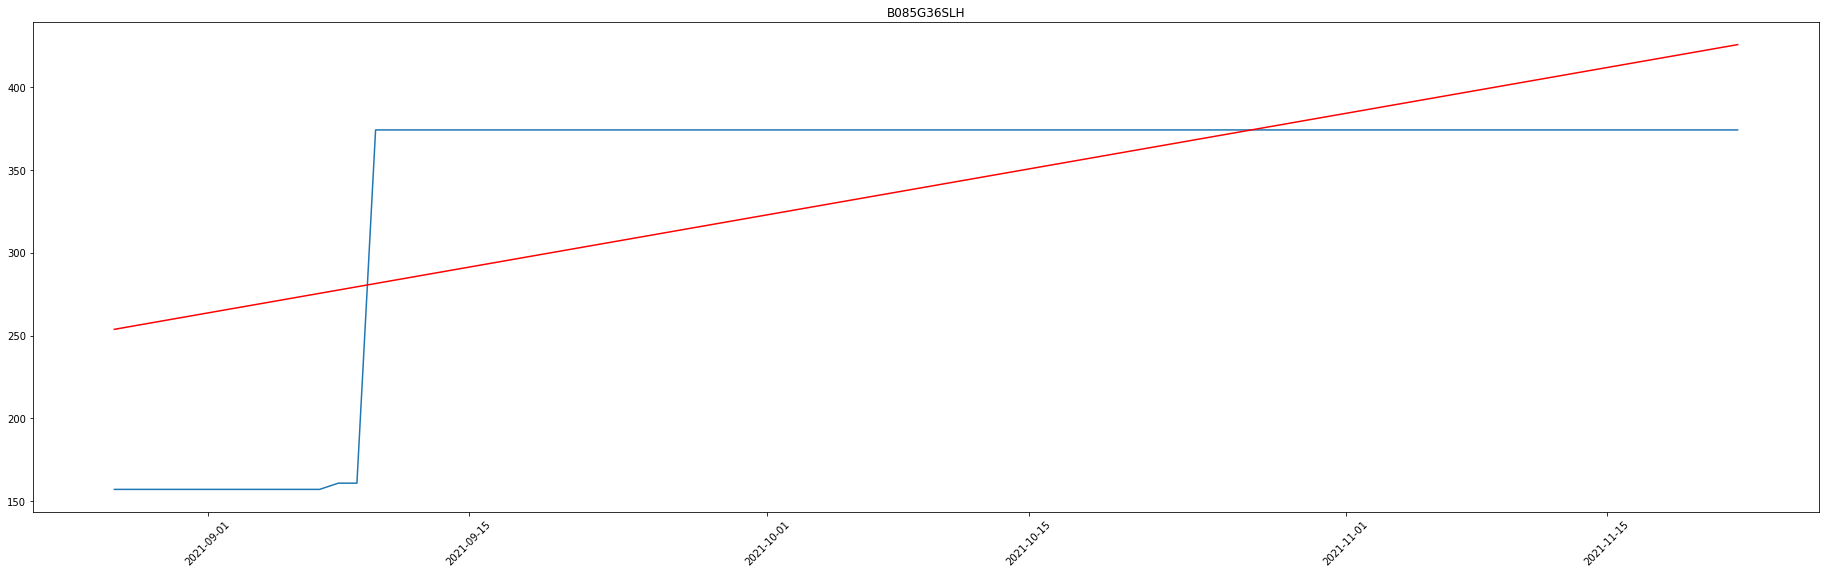

In [ ]:
# tbd
# Plotting one brand-category combination
# Get the unique brand-category combinations 
# brand_metrics_daily_filtered.loc[:,["brand","category_id"]].drop_duplicates().head(20)

plt.figure(figsize=(32,9))
product_id = "B085G36SLH"
# B00CIH94M8

# Fitting the linear regression for each brand-category combination and finding the slope of the trend
def get_growth_rate(x, y):
  slope, intercept, r_value, p_value, std_err = sc.linregress(x, y)
  print(f"slope - {slope}; r_value - {r_value}; p_value - {p_value}; std_err - {std_err}")
  return (slope, intercept)  

temp = product_brand_daily_filtered.loc[(product_brand_daily_filtered["product_id"].eq(product_id)),["sample_date" ,"new_price"]]
date_oridinal = temp["sample_date"].map(dt.datetime.toordinal)
slope, intercept = get_growth_rate(date_oridinal, temp["new_price"])
temp["predicted"] = intercept + slope*date_oridinal
temp.index = temp["sample_date"]
plt.title(f"{product_id}")
plt.plot(temp["new_price"])
plt.plot(temp["predicted"], 'r', label='fitted line')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Computing the weightage for each category to arrive at the final score for the brand
# Category with more sales is given higher weightage. (Weight is calculated based on the daily_sales_share)

product_weights = product_brand_daily_filtered.groupby(by=["brand", "product_id"])["daily_sales"].sum().reset_index()
product_weights.loc[:,"weightage"] = product_weights.groupby(by=["brand"])["daily_sales"].transform(lambda x:x/x.sum())
product_weights.drop(columns=["daily_sales"],inplace=True)

In [ ]:
# Calcualting the total score of each brand as weighted sum of individual score across each category
weighted_pricing_score = pd.merge(product_weights, price_product_score, on=["brand", "product_id"], how="inner")
weighted_pricing_score["weighted_pricing_score"] = weighted_pricing_score["pricing_score"]*weighted_pricing_score["weightage"]
weighted_pricing_score = weighted_pricing_score.groupby(by="brand").sum().loc[:, "weighted_pricing_score"].reset_index()
weighted_pricing_score.rename(columns={"weighted_pricing_score":"pricing_score"}, inplace=True)

,brand,weighted_pricing_score
0,Cambridge,-0.095261
1,"""N/A""",0.006071
2,"""NA""",-0.001140
3,''N/A'',0.052844
4,(RED),-1.292239
...,...,...
3638,§ONAO\大直,0.000000
3639,✅ REGISTERROLL,0.006629
3640,✅ RegisterRoll,0.040769
3641,モレスキン(Moleskine),-0.005616


In [ ]:
brands = pd.merge(brands, weighted_pricing_score, on="brand", how="left")
brands.to_csv(source_path+"/final_scores/products.csv")

,brand,pricing_score
0,CLUE,-0.019115
1,Black N Red,-0.012504
2,Patriot Wholesale Direct,-0.013790
3,STMT,-0.004263
4,WE'RE NOT REALLY STRANGERS,NaN
...,...,...
4120,ImageMat,0.090227
4121,Launch X431,0.000000
4122,JIM OSBORN REPRODUCTIONS,0.000000
4123,JIM OSBORN REPRODUCTIONS,-0.011448


In [ ]:
brands.to_csv(source_path+"/final_scores/pricing.csv")

In [ ]:
# Another approach to identify the products that has null value for new_price for the entire time frame

# # Computing the number of records with new_price as null to the total number of records
# def ratio_of_null_count(df):
#   return df["new_price"].isna().sum()/df.shape[0]

# # Computing the ratio of days for which the new_price is null to the total number of days for which we have data for for that sample_id
# null_price_ratio = product_brand_daily.groupby(by="product_id").apply(ratio_of_null_count)
# # Identifying the products which has new_price as null for all the available sample_date
# null_price_products = null_price_ratio[null_price_ratio==1]

# # Removing the above products from the analysis
# product_brand_daily = product_brand_daily.loc[~product_brand_daily["product_id"].isin(null_price_products.index),:]

**Scoring on relative pricing**

Ratio of median price of the brand in a category to the median price in that category

In [ ]:
# Joining product_metrics_daily to products to obtain the brand information for each product
# Note: category_id in product_metrics_daily is same as main_sales_rank_category_id in products
product_brand_daily = pd.merge(product_metrics_daily, products, on="product_id", how="inner", validate="many_to_one")
product_brand_daily["new_price"].replace(-1, np.nan, inplace=True)

In [ ]:
# Finding the average price of each of the product across the time frame
product_average_price = product_brand_daily.groupby(by=["product_id", "brand", "category_id"])["new_price"].sum().reset_index()
# There are few products with average new_price as 0. This might be because data not available for any of the date. 
# Removing such products from the analysis
product_average_price = product_average_price.loc[product_average_price["new_price"]!=0,:]

In [ ]:
# Finding the median price of products in each category
category_median_price = product_average_price.groupby(by=["category_id"]).median().reset_index()
# Finding the median price of products of each brand in a particular category
brand_category_median_price = product_average_price.groupby(by=["brand", "category_id"])["new_price"].median().reset_index()

# Calculating the score of brand-category combination as a ratio of the price of the median brand in a category to the median price of the category
brand_category_price = pd.merge(brand_category_median_price, category_median_price, on="category_id", how="left", validate="many_to_one", suffixes=(None, "_category"))
brand_category_price["price_ratio"] = brand_category_price["new_price"]/brand_category_price["new_price_category"]
brand_category_price

##### **Competition level** 
Number of other brands that sell products in the same category. This has to be calculated at day level.
> High level tasks
 - Data will have to be sourced by combining products and bi_product_metrics_daily.
 - For each brand identify the products sold on a given date and corresponding categories. Find the brands that sold products from the same category on the same date
 - That would provide us the number of brands that sells products in the same category as a given brand and category for a given date
 - Compute the average competition count for a timeframe

In [ ]:
product_details_daily = pd.merge(product_metrics_daily, products, on="product_id", how="inner", validate="many_to_one")
product_details_daily = product_details_daily.loc[:, [ "sample_date", "category_id", "brand"]]
# Only if we are finding the competitor count for the week
product_details_daily["week_number"] = pd.to_datetime(product_details_daily["sample_date"]).dt.isocalendar().week
product_details_daily["month_number"] = pd.to_datetime(product_details_daily["sample_date"]).dt.month

In [ ]:
# Code to identify the monthly competitor count
def get_competition_count(df):
  temp = pd.merge(df, df, on=["month_number", "category_list"], how="inner")
  competition_list = temp.loc[temp["brand_x"]!=temp["brand_y"], :].groupby(by=["brand_x", "month_number"])["brand_y"].nunique().reset_index()
  competition_list.rename(columns={"brand_x": "brand", "brand_y":"competition_count"}, inplace=True)2
  return competition_list

start = dt.datetime.now()
category_list = product_details_daily.groupby(by=["brand", "month_number"]).apply(lambda x:list(x["category_id"].unique())).reset_index()
category_list.rename(columns={0:"category_list"}, inplace=True)
category_list_exploded = category_list.explode("category_list")
competition = pd.DataFrame()
for month in list(category_list_exploded["month_number"].unique()):
  df = category_list_exploded.loc[category_list_exploded["month_number"]==month, :]
  competition = competition.append(get_competition_count(df))
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")
competition

Time taken - 39 seconds


,brand,month_number,competition_count
0,Cambridge,8,3741
1,"""N/A""",8,3741
2,"""NA""",8,3741
3,''N/A'',8,3741
4,(RED),8,3741
...,...,...,...
3999,✅ REGISTERROLL,11,3995
4000,✅ RegisterRoll,11,3995
4001,コクヨ(KOKUYO),11,3995
4002,モレスキン(Moleskine),11,3995


In [ ]:
def get_monthly_growth_rate(df, field_name):
  slope, intercept, r_value, p_value, std_err = sc.linregress(df["month_number"], df[field_name])
  return slope

competition_score = competition.groupby(by="brand").apply(get_monthly_growth_rate, "competition_count")

In [ ]:
# Code to identify the daily competitor count. This won't work due to computational limitation
# def get_competition_count(brand, date, category_list):
#   condition = (product_details_daily["sample_date"]==date) & (product_details_daily["brand"]!=brand) & (product_details_daily["category_id"].isin(category_list))
#   return len(set(list(product_details_daily.loc[condition, "brand"])))

# start = dt.datetime.now()
# category_list = product_details_daily.groupby(by=["brand", "sample_date"]).apply(lambda x:list(x["category_id"].unique())).reset_index()
# category_list.rename(columns={0:"category_list"}, inplace=True)
# # competition = category_list.apply(lambda x: get_competition_count(x["brand"], x["sample_date"], x["category_list"]), axis=1)
# print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")

### ***Periodic***
In this list of KPIs, we analyse the period as a whole and come up with an aggregate value for each of the brand for the whole time frame.

---
**KPIs**
  1. Competition (see Shay’s calculations about entropy, ratio to leader/s, amazon selling, pricing levels)
  2. Out of stock rates
  3. Product revenue concentration
  4. Category revenue concentration
---

##### **Entropy**

##### **Amazon Selling**


##### **Pricing Levels**

##### **Average Competitor Count**

In [ ]:
product_details_daily = pd.merge(product_metrics_daily, products, on="product_id", how="inner", validate="many_to_one")
product_details_daily = product_details_daily.loc[:, [ "sample_date", "category_id", "brand"]]
# Only if we are finding the competitor count for the week/month
product_details_daily["week_number"] = pd.to_datetime(product_details_daily["sample_date"]).dt.isocalendar().week
product_details_daily["month_number"] = pd.to_datetime(product_details_daily["sample_date"]).dt.month

In [ ]:
# Code to identify the daily competitor count. This won't work due to computational limitation
def get_competition_count(brand, category_list):
  condition = (product_details_daily["brand"]!=brand) & (product_details_daily["category_id"].isin(category_list))
  return len(set(list(product_details_daily.loc[condition, "brand"])))

start = dt.datetime.now()
category_list = product_details_daily.groupby(by=["brand"]).apply(lambda x:list(x["category_id"].unique())).reset_index()
category_list.rename(columns={0:"category_list"}, inplace=True)

category_list_exploded = category_list.explode("category_list")
temp = pd.merge(category_list_exploded, category_list_exploded, on=["category_list"], how="inner")
competition_count = temp.loc[temp["brand_x"]!=temp["brand_y"], :].groupby(by=["brand_x"])["brand_y"].nunique().reset_index()
competition_count.rename(columns={"brand_x": "brand", "brand_y":"competition_count"}, inplace=True)

# Find the mean competitor count in 3 months
competition_score = competition_count.groupby(by="brand")["competition_count"].mean().reset_index()
# Find the competition score as the ratio of the competitor count to max competitor count
competition_score["competition_score"] = competition_score["competition_count"]/competition_score["competition_count"].max()
# Rescaling so that lower competition count has higher score
competition_score["competition_score"] = 1 - competition_score["competition_score"]
print(f"Time taken - {(dt.datetime.now() - start).seconds} seconds")
competition_score

Time taken - 11 seconds


,brand,competition_count,competition_score
0,Cambridge,3995.0,0.00125
1,"""N/A""",3995.0,0.00125
2,"""NA""",3995.0,0.00125
3,''N/A'',3995.0,0.00125
4,(RED),3995.0,0.00125
...,...,...,...
3999,✅ REGISTERROLL,3995.0,0.00125
4000,✅ RegisterRoll,3995.0,0.00125
4001,コクヨ(KOKUYO),3995.0,0.00125
4002,モレスキン(Moleskine),3995.0,0.00125


In [ ]:
brands = pd.merge(brands, competition_score.loc[:,["brand", "competition_score"]], on="brand", how="left", validate="one_to_one")

##### **Ratio to leader/s**

In [ ]:
# Finding the top brand sales in each category
ratio_to_leaders = brand_metrics_daily.groupby(by=["brand", "category_id"])["daily_sales"].mean().reset_index()
ratio_to_leaders["max_daily_sales"] = ratio_to_leaders.groupby(by="category_id")["daily_sales"].transform(max)
ratio_to_leaders["ratio_to_leader"] = ratio_to_leaders["daily_sales"]/ratio_to_leaders["max_daily_sales"]
category_sales_weights = category_weight(ratio_to_leaders, "daily_sales")
ratio_to_leaders = pd.merge(ratio_to_leaders, category_sales_weights, on=["brand", "category_id"], how="inner")
ratio_to_leaders["weighted_ratio"] = ratio_to_leaders["ratio_to_leader"]*ratio_to_leaders["weightage"]
ratio_to_leaders_score = ratio_to_leaders.groupby(by="brand")["weighted_ratio"].sum().reset_index()
ratio_to_leaders_score.rename(columns={"weighted_ratio":"ratio_to_leaders_score"}, inplace=True)

In [ ]:
brands = pd.merge(brands, ratio_to_leaders_score, on="brand", how="left", validate="one_to_one")

##### **Out of stock rates**

In [ ]:
# out_of_stock for the whole time frame.
# There are null values in the joined table, but it is removed while calculating the mean out_of_stock_pct
out_of_stocks = pd.merge(product_snapshots, products, on="product_id", how="inner", validate="one_to_one").loc[:,["product_id", "brand","out_of_stock_pct"]]

# Replacing -1 with NaN as -1 indicate mmissing value
out_of_stocks["out_of_stock_pct"].replace( -1, np.nan, inplace=True)

# Missing values in out_of_stock_pct is ignored while computing the mean. Also the null values in brand is also ignored
out_of_stock_score = out_of_stocks.groupby(by="brand")["out_of_stock_pct"].mean().reset_index()

# Rescaling so that 0% out_of_stock_pct has highest score and 100% out_of_stock_pct has lowest score
out_of_stock_score["out_of_stock_score"] = out_of_stock_score["out_of_stock_pct"].map(lambda x:(100-x)/100)
out_of_stock_score.drop(columns=["out_of_stock_pct"], inplace=True)

In [ ]:
brands = pd.merge(brands, out_of_stock_score, on="brand", how="left", validate="one_to_one")

##### **Product revenue concentration**
Measure how the total revenue of the brand is distributed across its products. This consists of two parts - 
 - Number of products each brand has
 - How the revenue is distributed across the products

**Discussion Points**

- Use total sales of the brands across products and then use that to check how it is distributed for calculating product_revenue_concenteration
- Arrive at the final score by multiplying product concenteration and product revenue concenteration
- Check for discrepancy if any in using the product_metrics_daily and brand_metrics_daily 

  - brand 1 - 10 product (average of products across total time frame)
  - brand 2 - 1 product (average of products across total time frame)
  - brand 3 - 5 product (average of products across total time frame)
  - median of 10,1,5 to get the 
  - then to get the score we dvide by median
  - brand 1 - 10/16
  - brand 2 - 1/16'

Question
- If we are using total sales of the each products across the time frame and then the distribution of sales of brand across the products, will that cause bias towards those products that sold through out the sample_date. Few products are sold only few days while few products are sold for the whole time frame
- Entropy calculated for product_revenue_distribution has been rescaled to 0 to 1 (0 indicating the total revenue of the brand across timeframe is concenterated in few product while 1 indicating the revenue is more or less uniformly distributed). Is this ok?


**Product concenteration metric**

In [ ]:
# Here we find the mean number of products across the time frame for each brand and represent it as a fraction of the median of mean number of products 
brand_product_conc = (brand_metrics_daily.groupby(by="brand")["products"].mean()/brand_metrics_daily.groupby(by="brand")["products"].mean().median()).reset_index()
brand_product_conc.rename(columns={"products":"product_conc"},inplace=True)

 **Product revenue concenteration metric**

In [ ]:
# Joining product_metrics_daily to products to obtain the brand information for each product
# Note: category_id in product_metrics_daily is same as main_sales_rank_category_id in products
product_brand_daily = pd.merge(product_metrics_daily, products, on="product_id", how="inner", validate="many_to_one")
product_brand_daily.replace(-1, np.nan, inplace=True)

In [ ]:
# Entropy is used to measure how uniformly the total revenue of the brand is distributed across its different products
# Entropy is lowest if the distribution is uniform while it is maximum if it s concenterated on few datapoints
# Drawback of entropy - If a brand has just one product it will have the lowest entropy (since it is always uniformly distributed)

brand_products = product_brand_daily.groupby(by=["brand", "product_id"])["daily_sales"].sum().reset_index()

# Function to calculate entropy
# We assign maximum entropy if the total sales of a brand (across all the brands) is 0 or if the brand has only one brand
calculate_entropy = lambda x:sc.entropy(x["daily_sales"]/x["daily_sales"].sum()) if x["daily_sales"].sum()!=0 and len(x["daily_sales"])>1 else 1000

# Calculating entropy for each brand based on daily_sales
brand_product_revenue_entropy = brand_products.groupby(by="brand").apply(calculate_entropy).reset_index()
brand_product_revenue_entropy.rename(columns={0:"product_revenue_entropy"}, inplace=True)

In [ ]:
# Finding the brand with maximum entropy (other than 1000)
max_entropy = brand_product_revenue_entropy.loc[brand_product_revenue_entropy["product_revenue_entropy"]!=1000, "product_revenue_entropy"].max()
# Replacing the entropy of 1000 with the second maximum value
brand_product_revenue_entropy["product_revenue_entropy"].replace(1000, max_entropy, inplace=True)

# Rescaling the entropy so that uniform distribution has highest score and concenterated distribution has lowest score
scaler = MinMaxScaler()
brand_product_revenue_entropy["product_revenue_conc"] = scaler.fit_transform(brand_product_revenue_entropy[["product_revenue_entropy"]])
brand_product_revenue_entropy["product_revenue_conc"] = brand_product_revenue_entropy["product_revenue_conc"].map(lambda x:1-x)
brand_product_revenue_entropy.drop(columns=["product_revenue_entropy"], inplace=True)

In [ ]:
brand_product_revenue_conc_score = pd.merge(brand_product_revenue_entropy, brand_product_conc, on="brand", how="inner", validate="one_to_one")
brand_product_revenue_conc_score["product_revenue_conc_score"] = brand_product_revenue_conc_score["product_conc"]*brand_product_revenue_conc_score["product_revenue_conc"]

In [ ]:
brand_product_revenue_conc_score.drop(columns=["product_conc", "product_revenue_conc"], inplace=True)
brands = pd.merge(brands, brand_product_revenue_conc_score, on="brand", how="left")

##### **Category revenue concentration**

**Discussion Points**

- Use total sales of the brands across products and then use that to check how it is distributed for calculating product_revenue_concenteration
- Arrive at the final score by multiplying product concenteration and product revenue concenteration
- Check for discrepancy if any in using the product_metrics_daily and brand_metrics_daily 


Question
- If we are using total sales of the each products across the time frame and then the distribution of sales of brand across the products, will that cause bias towards those products that sold through out the sample_date. Few products are sold only few days while few products are sold for the whole time frame
- Entropy calculated for product_revenue_distribution has been rescaled to 0 to 1 (0 indicating the total revenue of the brand across timeframe is concenterated in few product while 1 indicating the revenue is more or less uniformly distributed). Is this ok?


**Category concenteration metric**

In [ ]:
# Here we find the mean number of categories across the time frame for each brand and represent it as a fraction of the median of mean number of categories 
brand_category = brand_metrics_daily.groupby(by=["brand"]).nunique().reset_index()
brand_category.rename(columns={"category_id":"category_count"}, inplace=True)
brand_category_conc = (brand_category.groupby(by="brand")["category_count"].mean()/brand_category.groupby(by="brand")["category_count"].mean().median()).reset_index()
brand_category_conc.rename(columns={"category_count":"category_conc"},inplace=True)

 **Category revenue concenteration metric**

In [ ]:
brand_category_sales = brand_metrics_daily.groupby(by=["brand", "category_id"])["daily_sales_share"].sum().reset_index()

# Function to calculate entropy
# We assign maximum entropy if the total sales of a brand (across all the brands) is 0 or if the brand has only one brand
calculate_entropy = lambda x:sc.entropy(x["daily_sales_share"]/x["daily_sales_share"].sum()) if x["daily_sales_share"].sum()!=0 and len(x["daily_sales_share"])>1 else 1000

# Calculating entropy for each brand based on daily_sales
brand_category_revenue_entropy = brand_category_sales.groupby(by="brand").apply(calculate_entropy).reset_index()
brand_category_revenue_entropy.rename(columns={0:"category_revenue_entropy"}, inplace=True)

In [ ]:
# Finding the brand with maximum entropy (other than 1000)
max_entropy = brand_category_revenue_entropy.loc[brand_category_revenue_entropy["category_revenue_entropy"]!=1000, "category_revenue_entropy"].max()
# Replacing the entropy of 1000 with the second maximum value
brand_category_revenue_entropy["category_revenue_entropy"].replace(1000, max_entropy, inplace=True)

# Rescaling the entropy so that uniform distribution has highest score and concenterated distribution has lowest score
scaler = MinMaxScaler()
brand_category_revenue_entropy["category_revenue_conc"] = scaler.fit_transform(brand_category_revenue_entropy[["category_revenue_entropy"]])
brand_category_revenue_entropy["category_revenue_conc"] = brand_category_revenue_entropy["category_revenue_conc"].map(lambda x:1-x)
brand_category_revenue_entropy.drop(columns=["category_revenue_entropy"], inplace=True)

In [ ]:
brand_category_revenue_conc_score = pd.merge(brand_category_revenue_entropy, brand_category_conc, on="brand", how="inner", validate="one_to_one")
brand_category_revenue_conc_score["category_revenue_conc_score"] = brand_category_revenue_conc_score["category_conc"]*brand_category_revenue_conc_score["category_revenue_conc"]

In [ ]:
brand_category_revenue_conc_score.drop(columns=["category_conc", "category_revenue_conc"], inplace=True)
brands = pd.merge(brands, brand_category_revenue_conc_score, on="brand", how="left")
brands

,brand,competition_score,ratio_to_leaders_score,out_of_stock_score,product_revenue_conc_score,category_revenue_conc_score
0,CLUE,0.00125,0.005733,1.00,1.110223e-16,0.000000
1,Black N Red,0.00125,0.000342,1.00,1.110223e-16,0.000000
2,Patriot Wholesale Direct,0.00125,0.000564,1.00,1.110223e-16,0.000000
3,STMT,0.00125,0.247926,1.00,2.376472e+00,2.042832
4,WE'RE NOT REALLY STRANGERS,0.00125,0.005584,0.80,1.110223e-16,1.828637
...,...,...,...,...,...,...
4120,ImageMat,0.00125,0.000522,0.91,1.110223e-16,0.000000
4121,Launch X431,0.00125,0.000259,1.00,1.110223e-16,1.436703
4122,JIM OSBORN REPRODUCTIONS,0.00125,0.000601,1.00,1.110223e-16,0.000000
4123,JIM OSBORN REPRODUCTIONS,0.00125,0.000684,1.00,1.110223e-16,0.000000


In [ ]:
brands.to_csv(source_path+"/final_scores/periodic_metrices.csv")

### ***Snapshot***
In this list of KPIs, we analyse the data at a given point of time and come up with score that can be used to compare the brands.

---
**KPIs**
  1. Number of Sellers
  2. Brand sells its products not/exclusively
  3. Seller reviews (count/score)
  4. Product reviews
  5. Pricing
---
**Tasks**
 - General
   1. TODO

 - Specfic to metric
   1. TODO
---

##### **Number of Sellers**
Number of Sellers -bell curve, need to think where the optimum resides, probably depending on the product’s volume. Maybe we should look at the avg #sellers per product.

Metric - Measure how distant the value is from the mean value. Farther the value is lower the score is

Three approaches to find the number of sellers for the brand
  1. Use the "sellers" field in bi_brand_segmentation/brand_metrics_snapshot table. Prefer brand_metrics_snapshot since it have seller info for more brands
  Challenges with this approach 
    - This is an absolute value and does not take in to the pictue the number of products a brand has. A brand with larger number of products would have larger number of seller
  2. Derive sellers per product (from brand_segmentation table)
  3. Use the product_offer_snapshot table to get the number of sellers for each product and then aggregate the number of sellers for the brand as weighted sum based on the product volume. (product_offer_snapshots table would have to be combined with products table to get the brand info). <br>
  Challenges with this approach 
    - We just have the seller data info for just 8802 products out of 22922 products and hence would not be using much of the available data
    - Weighted sum for number of sellers would become 0 if a product has 0 sales or if the sales of all the products of a brand is 0 

**Analysis**

In [ ]:
print(f"brand_metrics_snapshot - {brand_metrics_snapshot.shape}")
print(f"brand_segmentation - {brand_segmentation.shape}")
print(f"Number of null values in sellers field in brand_metrics_snapshot {brand_metrics_snapshot.loc[brand_metrics_snapshot['sellers'].isna()].shape}")
print(f"Number of null values in sellers field in brand_segmentation {brand_segmentation.loc[brand_segmentation['sellers'].isna()].shape}")

temp = pd.merge(brand_metrics_snapshot, brand_segmentation, on="brand", how="left", validate="one_to_one")
cols = ["brand", "sellers_x", "sellers_y"]
temp = temp.loc[(~temp["sellers_x"].eq(temp["sellers_y"])&(temp["sellers_y"].isna())), cols]
print(f"Number of additional valid records in brand_sellers: {temp.shape}")
# Since we do not have null values in the the seller field in the source tables, we can confirm that there are additional 121 records in brand_metrics_snapshot that are not present in brand_segmentation

print(f"Number of products in products: {products['product_id'].nunique()}")
print(f"Number of products in product_offer_snapshots: {product_offer_snapshots['product_id'].nunique()}")
print(f"Number of products in product_metrics_daily: {product_metrics_daily['product_id'].nunique()}")


brand_metrics_snapshot - (4116, 17)
brand_segmentation - (3995, 28)
Number of null values in sellers field in brand_metrics_snapshot (0, 17)
Number of null values in sellers field in brand_segmentation (0, 28)
Number of additional valid records in brand_sellers: (121, 3)
Number of products in products: 22922
Number of products in product_offer_snapshots: 8802
Number of products in product_metrics_daily: 21543


**Approach 1**

In [ ]:
number_of_sellers_score = brand_metrics_snapshot.loc[:, ["brand", "sellers"]]
number_of_sellers_score

,brand,sellers
0,Marketing Holders,1
1,Aquila Paper,1
2,FILIFALA88,1
3,Life of the Kind,1
4,ZOLUT MORE THAN SCHOOL SUPPLLIES,1
...,...,...
4111,TUL,70
4112,Staples,62
4113,Disney,70
4114,MUJI,61


**Approach 2**

In [ ]:
number_of_sellers_score = pd.DataFrame(brand_segmentation["brand"])
number_of_sellers_score["sellers"] = brand_segmentation["sellers"]/brand_segmentation["products"]
number_of_sellers_score.sort_values(by="sellers", inplace=True)
number_of_sellers_score

,brand,sellers
2884,Boutique Marketing LLC,0.009524
468,Discount Magnets,0.011765
2872,RXBC2011,0.014925
3396,1InTheOffice,0.015504
3641,Desktop Publishing Supplies,0.018349
...,...,...
2245,Stranger Things,24.000000
3872,Quadow,25.000000
1742,Rediform Office Products Corporation - Products,26.000000
3184,Spellbinders,28.000000


**Approach 3**

In [ ]:
# Combining product_offer_snapshots and products table
product_sellers = pd.merge(product_offer_snapshots, products, on="product_id", how="inner", validate="many_to_one")
product_sellers = product_sellers.loc[:,["product_id", "brand", "seller_id"]]
# Finding the average items sold for each product
product_avg_sales = product_metrics_daily.groupby(by="product_id")["daily_items"].mean().reset_index()
# Finding the count of sellers for each product_id
product_sellers = product_sellers.groupby(by=["product_id", "brand"])["seller_id"].count().reset_index()
# Combining product_sellers and product_avg table
product_sellers = pd.merge(product_sellers, product_avg_sales, on="product_id", how="inner", validate="many_to_one")
# Finding the weights for each product based on its sales contribution to the brand
product_sellers["weightage"] = product_sellers.groupby(by="brand")["daily_items"].transform(lambda x:x/x.sum() if x.sum()>0 else 0)
# Calculating weighted sum of the sellers
product_sellers["weighted_sellers"] = product_sellers["seller_id"]*product_sellers["weightage"]
number_of_sellers_score = product_sellers.groupby(by="brand").apply(lambda x:x["weighted_sellers"].sum() if x["weighted_sellers"].sum()>0 else x["seller_id"].sum()).reset_index()
number_of_sellers_score.rename(columns={0: "sellers"}, inplace=True)
number_of_sellers_score

,brand,sellers
0,Cambridge,17.000000
1,"""N/A""",1.000000
2,"""NA""",1.000000
3,''N/A'',1.000000
4,(RED),8.000000
...,...,...
3991,✅ REGISTERROLL,3.000000
3992,✅ RegisterRoll,2.903945
3993,コクヨ(KOKUYO),2.364348
3994,モレスキン(Moleskine),20.000000


**Calculating the score**

In [ ]:
mean = number_of_sellers_score["sellers"].mean()
std = number_of_sellers_score["sellers"].std()
# Finding the z-score - the distance of the vaule from the mean value as a measure of standard deviation
number_of_sellers_score["number_of_sellers_score"] = ((number_of_sellers_score["sellers"] - mean)/std).abs()
number_of_sellers_score.sort_values(by="number_of_sellers_score", inplace=True)
# Rescaling so that farther the distance, lower the score is
number_of_sellers_score["number_of_sellers_score"] = number_of_sellers_score["number_of_sellers_score"].max()-number_of_sellers_score["number_of_sellers_score"]

# TODO - In case the number of sellers is 0 then it has to be replaced with the maximum value (This would occur only for Approach 3)

number_of_sellers_score.sort_values(by="sellers")

,brand,sellers,number_of_sellers_score
2966,Satumu,1.0,1.491936e+00
3098,Stationery Creations,1.0,1.491936e+00
2447,POVOKICI,1.0,1.491936e+00
681,Craftiff,1.0,1.491936e+00
572,Censen,1.0,1.491936e+00
...,...,...,...
2972,Scholastic,20.0,4.440892e-16
1231,GoWrite!,20.0,4.440892e-16
2752,Rae Dunn,20.0,4.440892e-16
461,Business Source,20.0,4.440892e-16


In [ ]:
brands = pd.merge(brands, number_of_sellers_score.loc[:, ["brand", "number_of_sellers_score"]], on="brand", how="left", validate="one_to_one")

,brand,number_of_sellers_score
0,CLUE,9.520273e-01
1,Black N Red,8.881784e-16
2,Patriot Wholesale Direct,1.967949e+00
3,STMT,2.935350e-01
4,WE'RE NOT REALLY STRANGERS,1.650607e+00
...,...,...
4120,ImageMat,1.650607e+00
4121,Launch X431,1.650607e+00
4122,JIM OSBORN REPRODUCTIONS,1.491936e+00
4123,JIM OSBORN REPRODUCTIONS,1.650607e+00


##### **Brand sells its products not/exclusively**

We can get the number of sellers each brand has directly from bi_brand_metrics_snapshot and bi_brand_segmentation.
Else we can get the sellers that sells each product from product_offer_snapshot and then combine it with product table

##### **Seller Reviews Count**

We already have the reviews_score and reviews_count in the following tables
1. bi_brand_metrics_snapshot
2. bi_brand_segmentation
3. bi_brand_sellers

bi_brand_segmentation is more enriched with additional columns but bi_brand_metrics contain valid score and count for more number of brands when compared to bi_brand_segmentation.
bi_brand_sellers contain individual seller score and count for each of the brand and will have to take mean to get average seller score

Better to take seller score and count from brand_metrics_snapshot due to the following reason
  1. It is already averages score for each brand
  2. Values are same when compared with corresponding values in bi_brand_segmentation
  3. It has scores and count for additional 177 brands. bi_brand_segmentation does not have value for those brands

Note
 - Around 127 brand has null value for avg_seller_reviews_score and avg_seller_reviews_count in both bi_brand_segmentation and bi_brand_metrics
 - For 117 brands, we hvae value in bi_brand_metrics but is null value in bi_brand_segmentations
 - 4 brands in bi_brand_metrics and that are not present in bi_brand_segmentation has null value even in bi_brand_metrics

In [ ]:
print(f"Shape of brand_metrics_snapshot: {brand_metrics_snapshot.shape}")
print(f"Unique brands in brand_metrics_snapshot: {brand_metrics_snapshot['brand'].nunique()}")
print(f"Null review score: {(~brand_metrics_snapshot['avg_seller_reviews_score'].isna()).sum()}")
print(f"Null review count: {(~brand_metrics_snapshot['avg_seller_reviews_count'].isna()).sum()}")

Shape of brand_metrics_snapshot: (4116, 17)
Unique brands in brand_metrics_snapshot: 4116
Null review score: 3985
Null review count: 3985


In [ ]:
print(f"Shape of brand_segmentation: {brand_segmentation.shape}")
print(f"Unique brands in brand_segmentation: {brand_segmentation['brand'].nunique()}")
print(f"Null review score: {(~brand_segmentation['avg_seller_reviews_score'].isna()).sum()}")
print(f"Null review count: {(~brand_segmentation['avg_seller_reviews_count'].isna()).sum()}")

Shape of brand_segmentation: (3995, 28)
Unique brands in brand_segmentation: 3995
Null review score: 3868
Null review count: 3868


In [ ]:
# print(f"Shape of brand_sellers: {brand_sellers.shape}")
# print(f"Unique brands in brand_sellers: {brand_sellers['brand'].nunique()}")
# brand_sellers.head()
# temp = brand_sellers.groupby(by="brand").mean().loc[:, ["reviews_score", "reviews_count"]]
# print(f"Null review score: {(~temp['reviews_score'].isna()).sum()}")
# print(f"Null review count: {(~temp['reviews_count'].isna()).sum()}")

In [ ]:
# Checking if the avg_seller_reviews_score of brand_segmentation is same as brand_metrics_snapshot
temp = pd.merge(brand_metrics_snapshot, brand_segmentation, on="brand", how="inner", validate="one_to_one")
cols = ["brand", "avg_seller_reviews_score_x", "avg_seller_reviews_score_y", "avg_seller_reviews_count_x", "avg_seller_reviews_count_y"]
temp = temp.loc[~(temp["avg_seller_reviews_score_x"].eq(temp["avg_seller_reviews_score_y"])) | ~(temp["avg_seller_reviews_count_x"].eq(temp["avg_seller_reviews_count_y"])), cols]
print(temp.shape)
# count = temp.loc[(temp["avg_seller_reviews_score_x"].isna()) &(~temp["avg_seller_reviews_score_x"].isna()), :].shape[0]
# print(f"Non-matching {count}")
print(f"Non null avg_reveiw_score in brand_metrics_snapshot: {(~temp['avg_seller_reviews_score_x'].isna()).sum()}")
print(f"Non null avg_reveiw_score in brand_metrics_snapshot: {(~temp['avg_seller_reviews_count_x'].isna()).sum()}")
print(f"Non null avg_reveiw_score in brand_segmentation: {(~temp['avg_seller_reviews_score_y'].isna()).sum()}")
print(f"Non null avg_reveiw_score in brand_segmentation: {(~temp['avg_seller_reviews_score_y'].isna()).sum()}")

(127, 5)
Non null avg_reveiw_score in brand_metrics_snapshot: 0
Non null avg_reveiw_score in brand_metrics_snapshot: 0
Non null avg_reveiw_score in brand_segmentation: 0
Non null avg_reveiw_score in brand_segmentation: 0


In [ ]:
# Brands that are not present in the brand_segmentation but still have null value for avg_seller_reviews_score and avg_seller_reviews_count
brand_metrics_snapshot.loc[(brand_metrics_snapshot["avg_seller_reviews_score"].isna()) & ~(brand_metrics_snapshot["brand"].isin(list(temp["brand"]))), :]

,brand,sellers,avg_seller_reviews_score,avg_seller_reviews_count,avg_product_price_gap,offers,is_amazon,is_fba,is_fbm,is_prime,is_map,is_shipped_from_china,is_scam,is_condition_new,is_condition_used,is_condition_refurbished,is_condition_other
249,Amazon,1,NaN,NaN,0.0,1,1,0,1,1,0,0,0,1,0,0,0
1422,RAK TRACK,1,NaN,NaN,0.0,1,0,1,0,1,0,0,0,1,0,0,0
1457,Petite Petitions,1,NaN,NaN,0.0,1,0,1,0,1,0,0,0,1,0,0,0
1478,StrategyTraining.com,1,NaN,NaN,0.0,1,0,1,0,1,0,0,0,1,0,0,0


In [ ]:
seller_reviews_count = brand_metrics_snapshot.loc[:, ["brand", "avg_seller_reviews_count"]]
scaler = MinMaxScaler()
seller_reviews_count["seller_reviews_count"] = scaler.fit_transform(seller_reviews_count[["avg_seller_reviews_count"]])

,brand,avg_seller_reviews_count,seller_reviews_count
0,Marketing Holders,6584.000000,0.012782
1,Aquila Paper,703.000000,0.001363
2,FILIFALA88,2.000000,0.000002
3,Life of the Kind,156.000000,0.000301
4,ZOLUT MORE THAN SCHOOL SUPPLLIES,12.000000,0.000021
...,...,...,...
4111,TUL,5995.467391,0.011640
4112,Staples,6113.141026,0.011868
4113,Disney,11923.333333,0.023150
4114,MUJI,1306.434211,0.002535


In [ ]:
brands = pd.merge(brands, seller_reviews_count.loc[:, ["brand", "seller_reviews_count"]], on="brand", how="left", validate="one_to_one")

,brand,number_of_sellers_score,seller_reviews_count
0,CLUE,9.520273e-01,0.003031
1,Black N Red,8.881784e-16,0.171287
2,Patriot Wholesale Direct,1.967949e+00,0.004190
3,STMT,2.935350e-01,0.014919
4,WE'RE NOT REALLY STRANGERS,1.650607e+00,0.000085
...,...,...,...
4120,ImageMat,1.650607e+00,0.257783
4121,Launch X431,1.650607e+00,0.001353
4122,JIM OSBORN REPRODUCTIONS,1.491936e+00,0.005862
4123,JIM OSBORN REPRODUCTIONS,1.650607e+00,0.007264


##### **Seller Reviews Score**

In [ ]:
seller_reviews_score = brand_metrics_snapshot.loc[:, ["brand", "avg_seller_reviews_score"]]
scaler = MinMaxScaler()
seller_reviews_score["seller_reviews_score"] = scaler.fit_transform(seller_reviews_score[["avg_seller_reviews_score"]])

,brand,avg_seller_reviews_score,seller_reviews_score
0,Marketing Holders,87.000000,0.870000
1,Aquila Paper,97.000000,0.970000
2,FILIFALA88,50.000000,0.500000
3,Life of the Kind,100.000000,1.000000
4,ZOLUT MORE THAN SCHOOL SUPPLLIES,92.000000,0.920000
...,...,...,...
4111,TUL,90.717391,0.907174
4112,Staples,94.782051,0.947821
4113,Disney,95.344086,0.953441
4114,MUJI,95.592105,0.955921


In [ ]:
brands = pd.merge(brands, seller_reviews_score.loc[:, ["brand", "seller_reviews_score"]], on="brand", how="left", validate="one_to_one")

,brand,number_of_sellers_score,seller_reviews_count,seller_reviews_score
0,CLUE,9.520273e-01,0.003031,0.938571
1,Black N Red,8.881784e-16,0.171287,0.819412
2,Patriot Wholesale Direct,1.967949e+00,0.004190,1.000000
3,STMT,2.935350e-01,0.014919,0.916250
4,WE'RE NOT REALLY STRANGERS,1.650607e+00,0.000085,0.980000
...,...,...,...,...
4120,ImageMat,1.650607e+00,0.257783,0.750000
4121,Launch X431,1.650607e+00,0.001353,0.860000
4122,JIM OSBORN REPRODUCTIONS,1.491936e+00,0.005862,0.980000
4123,JIM OSBORN REPRODUCTIONS,1.650607e+00,0.007264,0.950000


##### **Product Reviews Count**

In [ ]:
product_reviews_count = brand_segmentation.loc[:, ["brand", "avg_product_reviews_count"]]
scaler = MinMaxScaler()
product_reviews_count["product_reviews_count"] = scaler.fit_transform(product_reviews_count[["avg_product_reviews_count"]])

,brand,avg_product_reviews_count,product_reviews_count
0,why-Islam,3.000000,0.000361
1,Gentle Meow,NaN,NaN
2,AcrylicBlank,1.000000,0.000180
3,Weatlake,3.000000,0.000361
4,A.K.,NaN,NaN
...,...,...,...
3990,Designworks Ink,67.526147,0.006183
3991,Journals Unlimited,158.904485,0.014428
3992,Disney,133.111992,0.012101
3993,MUJI,103.438680,0.009424


In [ ]:
brands = pd.merge(brands, product_reviews_count.loc[:, ["brand", "product_reviews_count"]], on="brand", how="left", validate="one_to_one")

##### **Product Reviews Score**

In [ ]:
product_reviews_score = brand_segmentation.loc[:, ["brand", "avg_product_reviews_score"]]
scaler = MinMaxScaler()
product_reviews_score["product_reviews_score"] = scaler.fit_transform(product_reviews_score[["avg_product_reviews_score"]])

In [ ]:
brands = pd.merge(brands, product_reviews_score.loc[:, ["brand", "product_reviews_score"]], on="brand", how="left", validate="one_to_one")

##### Pricing

In [ ]:
# Combining product_offer_snapshots and products table
non_null_price_products = product_offer_snapshots.loc[product_offer_snapshots["recent_price"]!=-1]
product_sellers = pd.merge(non_null_price_products, products, on="product_id", how="inner", validate="many_to_one")
product_sellers = product_sellers.loc[:,["product_id", "brand", "recent_price"]]
# Finding min to max price ratio
get_price_ratio = lambda x:x["recent_price"].min()/x["recent_price"].max() if x["recent_price"].max() != 0 else 0
product_sellers = product_sellers.groupby(by=["product_id", "brand"]).apply(get_price_ratio).reset_index()
product_sellers.rename(columns={0:"price_ratio"}, inplace=True)

# Finding the average sales for each product
product_avg_sales = product_metrics_daily.groupby(by="product_id")["daily_sales"].mean().reset_index()
# Combining product_sellers and product_avg table
product_sellers = pd.merge(product_sellers, product_avg_sales, on="product_id", how="inner", validate="many_to_one")

# Finding the weights for each product based on its sales contribution to the brand
product_sellers["weightage"] = product_sellers.groupby(by="brand")["daily_sales"].transform(lambda x:x/x.sum() if x.sum()>0 else 0)
# Calculating weighted sum of the price_ratio
product_sellers["weighted_price_ratio"] = product_sellers["price_ratio"]*product_sellers["weightage"]
price_score = product_sellers.groupby(by="brand")["weighted_price_ratio"].sum().reset_index()
price_score.rename(columns={"weighted_price_ratio":"price_ratio_score"}, inplace=True)

,brand,price_ratio_score
0,Cambridge,0.374006
1,"""N/A""",1.000000
2,"""NA""",1.000000
3,''N/A'',1.000000
4,(RED),0.067717
...,...,...
3991,✅ REGISTERROLL,0.762627
3992,✅ RegisterRoll,0.960206
3993,コクヨ(KOKUYO),0.855797
3994,モレスキン(Moleskine),0.105488


In [ ]:
brands = pd.merge(brands, price_score.loc[:, ["brand", "price_ratio_score"]], on="brand", how="left", validate="one_to_one")
brands.to_csv(source_path+"/final_scores/snapshot_metrices.csv")
brands

,brand,number_of_sellers_score,seller_reviews_count,seller_reviews_score,product_reviews_count,product_reviews_score,price_ratio_score
0,CLUE,9.520273e-01,0.003031,0.938571,0.032533,0.960000,0.099700
1,Black N Red,8.881784e-16,0.171287,0.819412,0.002166,0.946667,0.157306
2,Patriot Wholesale Direct,1.967949e+00,0.004190,1.000000,0.020654,0.975333,0.692619
3,STMT,2.935350e-01,0.014919,0.916250,0.513760,0.979621,0.283264
4,WE'RE NOT REALLY STRANGERS,1.650607e+00,0.000085,0.980000,0.094082,0.980000,1.000000
...,...,...,...,...,...,...,...
4120,ImageMat,1.650607e+00,0.257783,0.750000,0.006013,0.944900,0.519463
4121,Launch X431,1.650607e+00,0.001353,0.860000,0.004836,0.964242,1.000000
4122,JIM OSBORN REPRODUCTIONS,1.491936e+00,0.005862,0.980000,NaN,NaN,1.000000
4123,JIM OSBORN REPRODUCTIONS,1.650607e+00,0.007264,0.950000,NaN,NaN,0.954051
